### Подключение библиотек и скриптов

In [1065]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
import xgboost as xgb

from datetime import datetime

%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 11})

import warnings
warnings.filterwarnings('ignore')

### Загрузка и просмотр данных

In [1066]:
TRAIN_DATASET_PATH = '/Users/michail_bulgakov/Documents/working hard/Python/Library/real-estate-price-prediction-moscow/train.csv' # y_train, y_valid
TEST_DATASET_PATH = '/Users/michail_bulgakov/Documents/working hard/Python/Library/real-estate-price-prediction-moscow/test.csv'

In [1067]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [1068]:
train_df.shape

(10000, 20)

### Уменьшение объема памяти

In [1069]:
def reduce_mem_usage(train_df):
    start_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_df.columns:
        col_type = train_df[col].dtype
        
        if col_type != object:
            c_min = train_df[col].min()
            c_max = train_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_df[col] = train_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_df[col] = train_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_df[col] = train_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_df[col] = train_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_df[col] = train_df[col].astype(np.float32)
                else:
                    train_df[col] = train_df[col].astype(np.float64)
        else:
            train_df[col] = train_df[col].astype('category')

    end_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train_df

In [1070]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [1071]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

### Типы данных и их преобразование

In [1072]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [1073]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Анализ данных 

In [1074]:
train_df['Price'].describe()

count     10000.000000
mean     214138.937500
std       92872.273438
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

In [1075]:
# находим среднее значение, моду и медиану
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()

In [1076]:
target_mean

214138.94

In [1077]:
target_median

192269.65625

In [1078]:
target_mode

0    182938.078125
1    204576.421875
2    238608.656250
3    298194.500000
Name: Price, dtype: float32

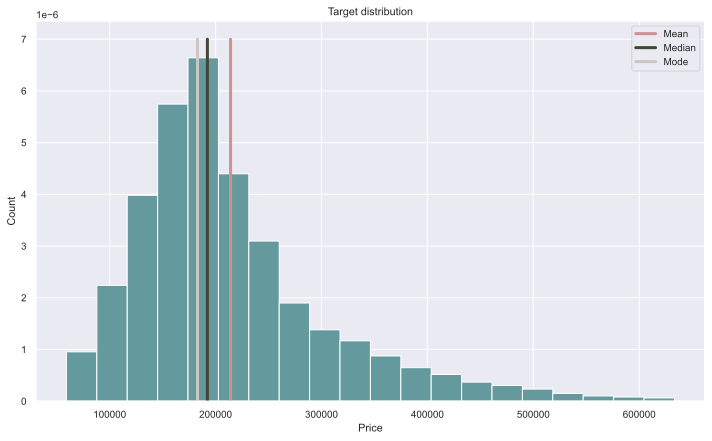

In [1079]:
# гистограмма изменения целевого признака
plt.figure(figsize = (12, 7))

train_df['Price'].hist(density = True, bins = 20, color = '#649a9e')

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label = "Mean", linewidth = 3, color = '#cc9293')
plt.plot([target_median] * 10, y, label = "Median", linewidth = 3, color = '#424632')
plt.plot([target_mode[0]] * 10, y, label = "Mode", linewidth = 3, color = '#cdc5c2')

plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')

plt.legend()
plt.show()

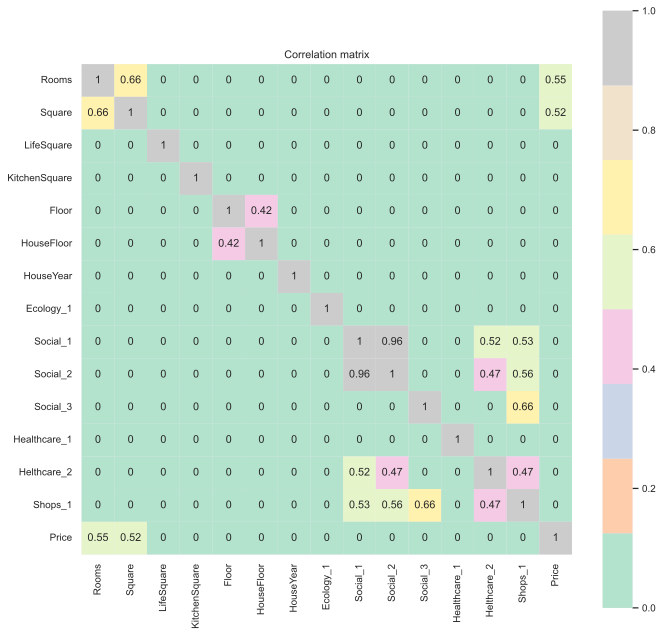

In [1080]:
# посмотрим на корреляцию признаков

plt.figure(figsize = (11, 11))

sns.set(font_scale = 0.9)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot = True,square = True, cmap = 'Pastel2', linewidths = False)

plt.title('Correlation matrix')
plt.show()

# Social_1 и Social_2 сильно коррелируют между собой, поэтому один из них можно будет удалить

### Обработка признаков

#### Номинативные признаки

In [1081]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


In [1082]:
# LifeSquare и HealthCare_1 имеют пропусти
# Странные значения Rooms и HouseYear

In [1083]:
train_df.select_dtypes(include = 'category').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [1084]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [1085]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [1086]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [1087]:
# Заметно, что объектов В значительно больше, чем объектов А
# Заменим B на 1, а A на 0
train_df['Ecology_2'] = (train_df['Ecology_2'] == 'B').astype(int)
train_df['Ecology_3'] = (train_df['Ecology_3'] == 'B').astype(int)
train_df['Shops_2'] = (train_df['Shops_2'] == 'B').astype(int)

In [1088]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.093750


#### Количественные признаки

In [1089]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [1090]:
# выделим в отдельный датафрейм
df_num_features = train_df.select_dtypes(include = ['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis = 1, inplace = True)

In [1091]:
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027313,NaN,10.0,10.0,0.075424,NaN
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0
3,1.0,40.409908,NaN,1.0,22.0,0.007122,NaN
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,NaN
...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,12.0,0.300323,NaN
9996,2.0,64.307686,37.038422,9.0,0.0,0.072158,NaN
9997,1.0,29.648056,16.555363,5.0,5.0,0.460556,NaN
9998,1.0,32.330292,22.326870,5.0,9.0,0.194489,125.0


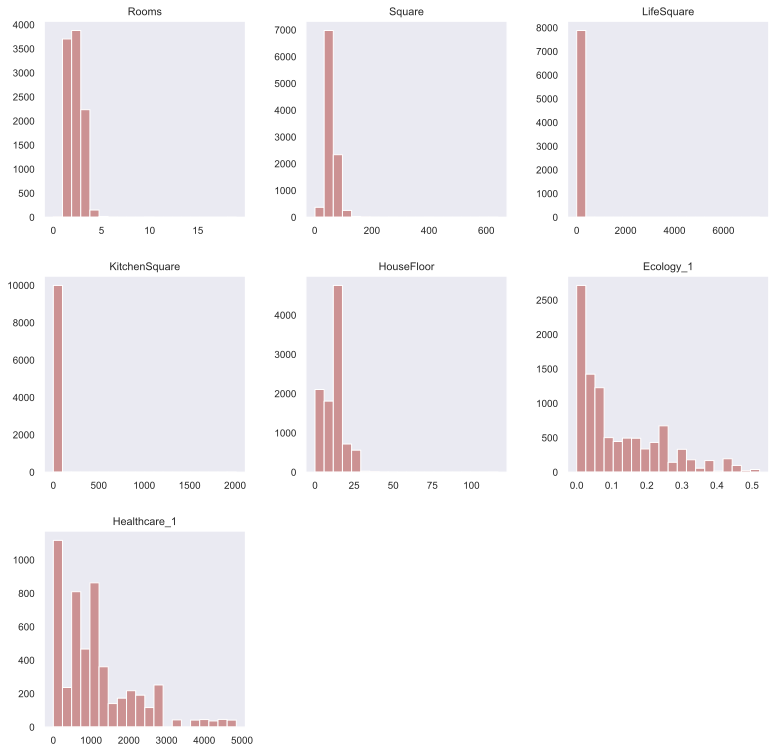

In [1092]:
# возможны выбросы
df_num_features.hist(figsize = (13, 13), bins = 20, grid = False, color = '#cc9293');

### Rooms

<AxesSubplot:>

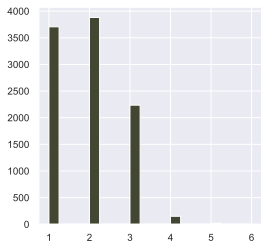

In [1093]:
train_df[(train_df['Rooms'] <= 6) & (train_df['Rooms'] >= 1)]['Rooms'].hist(figsize = (4, 4), bins = 20, color = '#424632')
# Считаем оптимальными значениями для признака промежуток [1, 6]. 
# В том случае, если значение признака равно 0, присваиваем ему единицу (квартира-студия).

In [1094]:
train_df.loc[train_df['Rooms'] < 1, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()

In [1095]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.093750
5,5804,99,3.0,62.528465,47.103832,6.0,9,9.0,1972,0.012339,1,1,35,5776,1,2078.0,2,4,1,161044.937500
6,8864,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,1,1,24,4860,1,80.0,0,3,1,142402.734375
7,13072,59,2.0,50.391815,32.893257,8.0,8,17.0,1986,0.019509,1,1,37,7687,11,176.0,5,5,1,326174.187500
8,9951,1,1.0,46.887894,44.628132,1.0,12,20.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,160400.406250
9,8094,6,3.0,79.867477,75.085129,1.0,3,17.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,1,194756.031250


### Square

In [1096]:
train_df.loc[(train_df['LifeSquare'] + train_df['KitchenSquare'] > train_df['Square']), ['Square', 'LifeSquare', 'KitchenSquare', 'Price']]

,Square,LifeSquare,KitchenSquare,Price
33,73.314972,74.131264,1.0,254005.375000
34,58.783661,55.441257,11.0,138396.984375
42,53.179790,50.643795,5.0,308108.218750
48,40.064915,38.733288,8.0,160810.546875
64,87.200623,87.730225,0.0,300180.375000
...,...,...,...,...
9960,96.056786,98.152802,1.0,524365.562500
9962,42.029175,44.682167,10.0,87556.382812
9979,40.043236,41.984322,1.0,134888.078125
9987,62.690056,64.602936,10.0,203908.187500


In [1097]:
train_df['KitchenSquare'].quantile(.99), train_df['KitchenSquare'].quantile(.01)

(16.0, 0.0)

In [1098]:
# Очевидно, что сумма LifeSquare и KitchenSquare в конечном итоге дают нам значение Square.
# Как видно даже из первых строк таблицы, значения совершенно не соответствуют логике.
# Выберем промежуток значений [5, 16] для площади кухни и заменим несоответствующие значения

In [1099]:
cond = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.99))
        
train_df.loc[cond, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [1100]:
train_df['LifeSquare'].quantile(.99), train_df['LifeSquare'].quantile(.01)

(95.65247, 2.8614628)

In [1101]:
train_df['LifeSquare'].median()

32.7812614440918

In [1102]:
# Поступим точно также.
# Предположим, что в списке данных есть квартиры-студии, тогда за минимальную площадь примем 20.

cond = (train_df['LifeSquare'].isna()) | (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.99))
        
train_df.loc[cond, 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['LifeSquare'] < 20, 'LifeSquare'] = 20

In [1103]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.718750
3,2352,1,1.0,40.409908,32.781261,5.0,10,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.093750


### HouseFloor

In [1104]:
train_df['HouseFloor'].quantile(.99), train_df['HouseFloor'].quantile(.01)

(25.0, 0.0)

In [1105]:
train_df['HouseFloor'].max()

117.0

In [1106]:
train_df['HouseFloor'].min()

0.0

In [1107]:
cond = (train_df['HouseFloor'].isna()) | (train_df['HouseFloor'] > train_df['HouseFloor'].quantile(.99))
        
train_df.loc[cond, 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1

In [1108]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.718750
3,2352,1,1.0,40.409908,32.781261,5.0,10,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,1,1,52,10311,6,NaN,1,9,1,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,1.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0,199715.156250
9997,2795,178,1.0,29.648056,20.000000,5.0,3,5.0,1958,0.460556,1,1,20,4386,14,NaN,1,5,1,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.406250


### Ecology_1

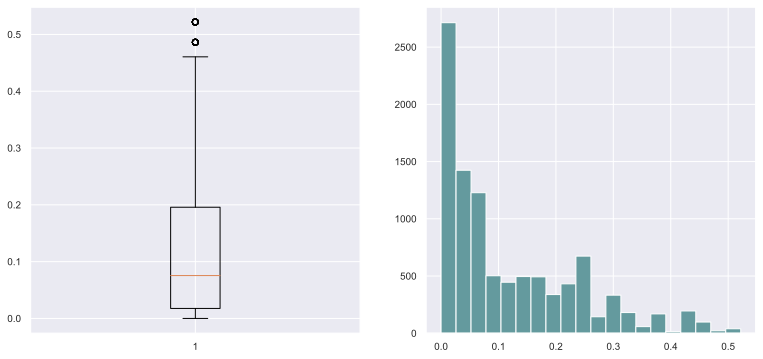

In [1109]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)

ax1, ax2 = ax.flatten()
ax1.boxplot(train_df['Ecology_1'], whis=1.5)
ax2.hist(train_df['Ecology_1'], bins = 20, color = '#649a9e')

fig.set_size_inches(13, 6)
plt.subplots_adjust(hspace = 0.5)

### Social_1, Social_2

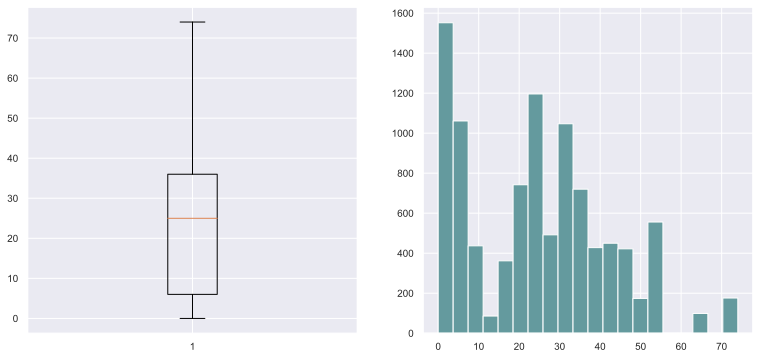

In [1110]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)

ax1, ax2 = ax.flatten()
ax1.boxplot(train_df['Social_1'], whis=1.5)
ax2.hist(train_df['Social_1'], bins = 20, color = '#649a9e')

fig.set_size_inches(13, 6)
plt.subplots_adjust(hspace = 0.5)

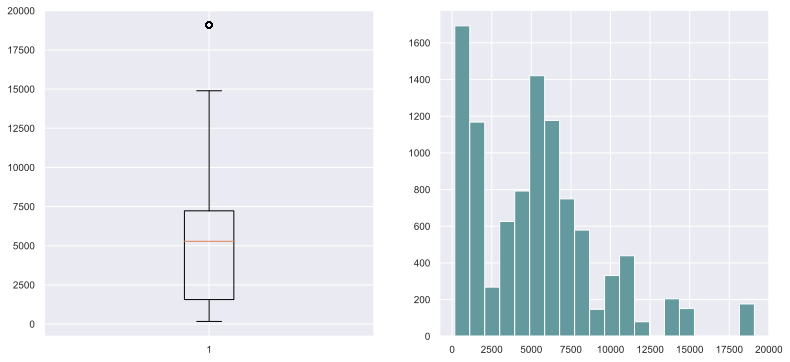

In [1111]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)

ax1, ax2 = ax.flatten()
ax1.boxplot(train_df['Social_2'], whis=1.5)
ax2.hist(train_df['Social_2'], bins = 20, color = '#649a9e')

fig.set_size_inches(13, 6)
plt.subplots_adjust(hspace = 0.5)

array([[<AxesSubplot:title={'center':'Social_2'}>]], dtype=object)

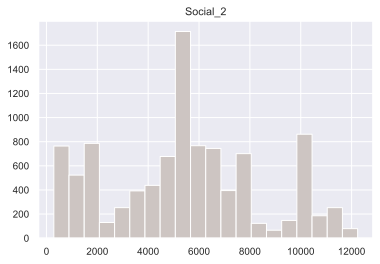

In [1112]:
train_df.loc[(train_df['Social_2'] <= train_df['Social_2'].quantile(.05)), 'Social_2'] = train_df['Social_2'].median()
train_df.loc[(train_df['Social_2'] >= train_df['Social_2'].quantile(.95)), 'Social_2'] = train_df['Social_2'].quantile(.95) - train_df['Social_2'].std()

train_df.hist('Social_2', bins=20, color = '#cdc5c2')

### Пропуски

In [1113]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [1114]:
# Неопределенный значения Healthcare_1 будем заменять медианой

In [1115]:
train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median, inplace=True)

In [1116]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Разбиение данных

In [1117]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 
                 'Shops_1', 'Shops_2']
target_name = 'Price'

In [1118]:
feature_names_for_stand = train_df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseFloor', 'Ecology_1']

In [1119]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train_df[feature_names_for_stand])

In [1120]:
stand_features

array([[ 1.3687193e+00,  2.7881296e+00, -1.8198091e-01,  1.3423071e+00,
        -3.9406863e-01, -3.6493102e-01],
       [-1.0930061e+00, -7.8276676e-01, -9.0843880e-01,  4.5822150e-01,
        -7.1025944e-01, -2.6897993e-03],
       [ 1.3687193e+00,  1.0460052e+00,  9.4342786e-01,  1.3423071e+00,
         7.1259928e-01, -7.8347254e-01],
       ...,
       [-1.0930061e+00, -1.2664130e+00, -1.1479620e+00, -8.6790675e-01,
        -1.1845458e+00,  2.8709531e+00],
       [-1.0930061e+00, -1.1390374e+00, -9.7210205e-01, -8.6790675e-01,
        -5.5216402e-01,  6.3545781e-01],
       [-1.0930061e+00, -9.7353083e-01, -9.7402948e-01, -4.2586398e-01,
        -5.5216402e-01,  7.1571417e-02]], dtype=float32)

In [1121]:
train_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [1122]:
train_df['Price'].astype('int64').dtypes

dtype('int64')

In [1123]:
X = train_df[feature_names]
y = train_df[target_name]

In [1124]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 42)

In [1125]:
def evaluate_preds(true_values, pred_values, save=False):    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [1129]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train) 

y_train_preds = lr_model.predict(X_train)

y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

TypeError: float() argument must be a string or a number, not 'method'

In [1127]:
#RF_model = RandomForestRegressor(criterion = 'mse',
#                                 max_depth = 20, # глубина дерева  
#                                 min_samples_leaf = 30, # минимальное кол-во наблюдений в листе дерева
#                                 random_state = 42,
#                                 n_estimators = 100  # кол-во деревьев
#                                 )
#
#RF_model.fit(X_train, y_train)
#y_train_preds = RF_model.predict(X_train)
#evaluate_preds(y_train, y_train_preds)

In [1128]:
#y_test_preds = rf_model.predict(X_test)
#evaluate_preds(y_test, y_test_preds)

In [ ]:
#gb_model = GradientBoostingRegressor(criterion='mse',
#                                     max_depth=7,
#                                     min_samples_leaf=10,
#                                     random_state=42,  
#                                    n_estimators=100)
#gb_model.fit(X_train, y_train)
#
#y_train_preds = gb_model.predict(X_train)
#evaluate_preds(y_train, y_train_preds)

In [1063]:
#y_test_preds = gb_model.predict(X_test)
#evaluate_preds(y_test, y_test_preds)